<a href="https://colab.research.google.com/github/ramirezvillanadialidia-byte/EDPII/blob/main/Extra_LIGV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resolver EDO  $-u'' = 1 - x^2$ para $ 0 < x < 1$  con condiciones de frontera en: $u(0) = u(1) = 0$ para $u(x)$ y $U_N$ , comparando ambas soluciones.

Usamos el método de elementos finitos

Definimos la funcion $f(x)=1-x^2$

In [ ]:
import sympy as sp
x = sp.Symbol('x')


f = 1 - x**2
f

1 - x**2

La malla contiene cuatro elementos entre 0 y 1, los cuales los hallamos con este código.

In [ ]:
n_elem = 4
h = sp.Rational(1, n_elem)
nodos = [i * h for i in range(n_elem + 1)]
nodos

[0, 1/4, 1/2, 3/4, 1]

El problema pide resolver para U y para $U_N$.
Para resolver en U, debemos resolver $u(x)$, como tenemos $-u''(x)$ primero:

Integramos dos veces para sacar $u(x)$, pero antes recordemos que primero tenemos $-u''(x)=1-x^2$ así que multiplicamos por $-1$ para tener $u''(x)=x^2-1$

In [ ]:
x = sp.symbols('x')
f = 1 - x**2
u_derivada = sp.integrate((-1)*f, x)
u = sp.integrate(u_derivada, x)


a, b = sp.symbols('a b')
u_original = u + a*x + b

sol = sp.solve([u_original.subs(x, 0), u_original.subs(x, 1)],(a, b))

u_original = u_original.subs(sol)

#las constantes a y b son:

print(f"a={sol[a]}")
print(f"b={sol[b]}")

print("Al reemplazar en la solución u(x) nos da:")
u_original


a=5/12
b=0
Al reemplazar en la solución u(x) nos da:


x**4/12 - x**2/2 + 5*x/12

La solución exacta es: $u(x)=\frac{x^4}{12}-\frac{x^2}{2}+\frac{5x}{12}$

Evaluamos la solución exacta $u(x)$ en los nodos internos, esto quiere decir, sin incluir el 0 y el 1.

In [ ]:
#definimos los nodos interiores, 1/4, 1/2 y 3/4
puntos = [sp.Rational(1, 4), sp.Rational(1, 2), sp.Rational(3, 4)]
valores = [u_original.subs(x, p) for p in puntos]

u_original_nodosint = sp.Matrix(valores)

u_original_nodosint

Matrix([
[75/1024],
[ 17/192],
[59/1024]])

Ahora para saber la solución $U_N$:

El problema nos pide una matriz K de rigidez y un vector de carga F. A continuación lo calcularemos en este código.

Este codigo ensambla la matriz de rigidez local y el vector de carga local

la matriz local es $K= \frac {1}{h}
\begin{bmatrix}1 & -1\\-1 & 1\end{bmatrix}$
Pero como $\frac{1}{h}=\frac{1}{1/4}=4$.



Entonces la matriz local resulta:
$\begin{bmatrix} 4 & -4\\ -4 & 4\end{bmatrix}$

Ahora a continuación construiremos la matriz de rigidez global, se construye sumando las contribuciones de cada elemento en los nodos donde se tocan. La cual ensambla la matriz local en una matriz 5x5, pues son 5 nodos.

El vector de carga $F$ se define como $F_i= \int_{x_i}^{x_j} f(x) \phi_i(x) \, dx$

Se obtiene integrando la función $f(x)=1-x^2$ y la función de sombrero $\phi_i(x) \ $

Recorre los nodos que definimos en el código como: $x_i$ y $x_j$, siendo $x_i$ el nodo anterior y $x_j$ el nodo siguiente


Componente del nodo anterior: ($i$): $f_1 = \int_{x_i}^{x_j} (1 - x^2) \phi_i(x) \, dx$    
Componente del nodo siguiente: ($j$): $f_2 = \int_{x_i}^{x_j} (1 - x^2) \phi_j(x) \, dx$

Así, el vector de carga F es: $F_i= \int_{x_i}^{x_j} (1 - x^2) \phi_i(x)\,dx +\int_{x_i}^{x_j} (1 - x^2) \phi_j(x) \, dx $

Las funciones sombrero se definen como: $\phi_i(x)\ =\frac {x_j-x}{h} $ y $ \phi_j(x)\ =\frac {x-x_i}{h}$ con $h=\frac{1}{4}$

Se evalúa esa integral en los 5 nodos para que nos dé el vector de carga.

In [ ]:
K = sp.zeros(n_elem + 1, n_elem + 1)
F = sp.zeros(n_elem + 1, 1)

for e in range(n_elem):
    x_i, x_j = nodos[e], nodos[e+1]
    phi_i = (x_j - x) / h
    phi_j = (x - x_i) / h
    bases = [phi_i, phi_j]


    for i in range(2):
        for j in range(2):
            K[e+i, e+j] += sp.integrate(sp.diff(bases[i], x) * sp.diff(bases[j], x), (x, x_i, x_j))
        F[e+i] += sp.integrate((1 - x**2) * bases[i], (x, x_i, x_j))



Matriz de rigidez global para 5 nodos.

In [ ]:
K

Matrix([
[ 4, -4,  0,  0,  0],
[-4,  8, -4,  0,  0],
[ 0, -4,  8, -4,  0],
[ 0,  0, -4,  8, -4],
[ 0,  0,  0, -4,  4]])

Vector local para 5 nodos.

In [ ]:
F

Matrix([
[95/768],
[89/384],
[71/384],
[41/384],
[ 5/256]])

Ahora aplicamos las condiciones de frontera, porque conocemos los valores de $u(0)=u(1)=0$ la matriz global resulta una de 3x3 y así hallar $u1, u2$ y $u3$.

Para hallar el vector de carga global, también evaluamos las condiciones de frontera $u(0)=u(1)=0$ para que nos quede una matriz 3x1.

In [ ]:
#Áca construimos las matrices K y F sin u=0 y u=1
K_cf = K[1:-1, 1:-1]
F_cf = F[1:-1, 0]


Nuestra matriz global queda como:

In [ ]:
K_cf

Matrix([
[ 8, -4,  0],
[-4,  8, -4],
[ 0, -4,  8]])

Nuestro vector global queda como:

In [ ]:
F_cf

Matrix([
[89/384],
[71/384],
[41/384]])

Ahora que tenemos K y F, tenemos el sistema de ecuaciones $Ku=F$.


Despejamos u para saber los valores de $u= u1,u2,u3$.


$u=K^{-1} F$

En el código, podemos resolver por LU

In [ ]:
#Resolvemos por LU
u_nodos_internos = K_cf.LUsolve(F_cf)
u_nodos_internos

Matrix([
[75/1024],
[ 17/192],
[59/1024]])

Así $\begin{bmatrix}
u1\\
u2\\
u3
\end{bmatrix} = \begin{bmatrix}
\frac{75}{1024}\\
\frac{17}{192}\\
\frac{59}{1024}
\end{bmatrix}$

Ahora incluimos los nodos 0 y 1 para tener la solución Un completa.

In [ ]:
# Resultado final de u_N en los nodos
u_N_final = [0] + [val for val in u_nodos_internos] + [0]
u_N_final

[0, 75/1024, 17/192, 59/1024, 0]

Esta es la solución para $U_N$

Calculamos el error en los nodos internos de: $u(x)$ y $U_N$

In [ ]:
import sympy as sp

error = abs(u_nodos_internos - u_original_nodosint)
error

Matrix([
[0],
[0],
[0]])

Notamos que el error es cero, ya que al evaluar en los puntos internos en $u(x)$ y $U_N$ tenemos los mismos valores.

Graficamos para verificarlo.

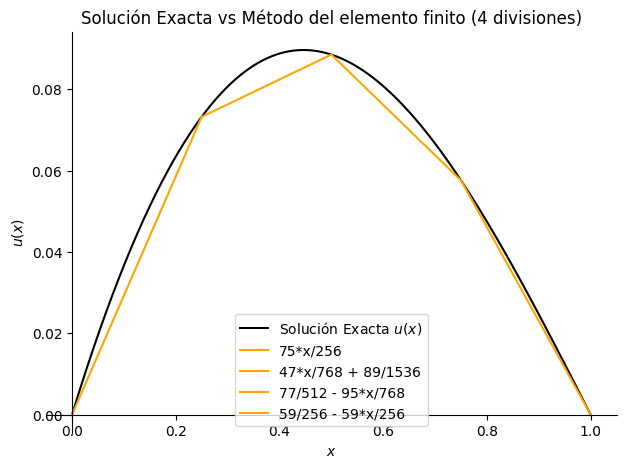

In [ ]:
import sympy as sp
from sympy.plotting import plot

#Graficamos u(x) la cual es una curva
p1 = sp.plot(u_original, (x, 0, 1), show=False, line_color='black', label='Solución Exacta $u(x)$')

#volvemos a definir los nodos como en el inicio para poder usarlos en la grafica de U_N
nodos = [i * h for i in range(n_elem + 1)]
#Graficamos U_N
points_x = [float(n) for n in nodos]
points_y = [float(val) for val in u_N_final]

#Para graficar los nodos, unimos los puntos mediante rectas y evaluamos los nodos en u_N_final
for i in range(n_elem):

    y1, y2 = u_N_final[i], u_N_final[i+1]
    x1, x2 = nodos[i], nodos[i+1]
    recta = y1 + (y2 - y1)/(x2 - x1) * (x - x1)
    p_segmento = sp.plot(recta, (x, x1, x2), show=False, line_color='orange', adaptive=False)
    p1.append(p_segmento[0])


p1.title = 'Solución Exacta vs Método del elemento finito (4 divisiones)'
p1.xlabel = '$x$'
p1.ylabel = '$u(x)$'
p1.legend = True
p1.show()